<a href="https://colab.research.google.com/github/mertege/FMCW-Data-Classification-/blob/Range-Doppler-Spectrogram-LSTM/RD_SP_LSTM_dropout_03_black.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dropout0.3

In [1]:
from keras.models import Sequential
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Normalization, Input, Conv2D, MaxPooling2D, Concatenate, GRU, LSTM, GRU, TimeDistributed, Bidirectional
import tensorflow as tf
import scipy.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from numpy.random import seed
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import EarlyStopping
from numpy import array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K 
import gc
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Get Range-Doppler data from
range_doppler_fast_resized = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_fast_resized.mat')
range_doppler_fast_resized = range_doppler_fast_resized['range_doppler_fast_resized']
range_doppler_fast_resized = np.transpose(range_doppler_fast_resized, (2, 0, 1))
# range_doppler_fast_resized = np.delete(range_doppler_fast_resized,(49), axis=0) # 50th row is deleted since there is no 50th row in spectrogram fast data.
range_doppler_fast_label = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_fast_label.mat')
range_doppler_fast_label = range_doppler_fast_label['range_doppler_fast_label']  

range_doppler_slow_resized = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_slow_resized.mat')
range_doppler_slow_resized = range_doppler_slow_resized['range_doppler_slow_resized']
range_doppler_slow_resized = np.transpose(range_doppler_slow_resized, (2, 0, 1))
range_doppler_slow_label = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_slow_label.mat')
range_doppler_slow_label = range_doppler_slow_label['range_doppler_slow_label']  

range_doppler_slow_pocket_resized = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_slow_pocket_resized.mat')
range_doppler_slow_pocket_resized = range_doppler_slow_pocket_resized['range_doppler_slow_pocket_resized']
range_doppler_slow_pocket_resized = np.transpose(range_doppler_slow_pocket_resized, (2, 0, 1))
range_doppler_pocket_label = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_pocket_label.mat')
range_doppler_pocket_label = range_doppler_pocket_label['range_doppler_pocket_label']  
# Get Range-Doppler data from
spectrogram_fast_resized = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_fast_resized.mat')
spectrogram_fast_resized = spectrogram_fast_resized['spectrogram_fast_resized']
spectrogram_fast_resized = np.transpose(spectrogram_fast_resized, (2, 0, 1))
spectrogram_fast_label = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_fast_label.mat')
spectrogram_fast_label = spectrogram_fast_label['spectrogram_fast_label']  

spectrogram_slow_resized = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_resized.mat')
spectrogram_slow_resized = spectrogram_slow_resized['spectrogram_slow_resized']
spectrogram_slow_resized = np.transpose(spectrogram_slow_resized, (2, 0, 1))
spectrogram_slow_label = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_label.mat')
spectrogram_slow_label = spectrogram_slow_label['spectrogram_slow_label']  

spectrogram_slow_pocket_resized = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_pocket_resized.mat')
spectrogram_slow_pocket_resized = spectrogram_slow_pocket_resized['spectrogram_slow_pocket_resized']
spectrogram_slow_pocket_resized = np.transpose(spectrogram_slow_pocket_resized, (2, 0, 1))
spectrogram_slow_pocket_label = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_pocket_label.mat')
spectrogram_slow_pocket_label = spectrogram_slow_pocket_label['spectrogram_slow_pocket_label']  

In [4]:
# Concat range-doppler data
range_doppler_concat = np.concatenate((range_doppler_fast_resized,range_doppler_slow_resized),axis=0)
range_doppler_concat = np.concatenate((range_doppler_concat,range_doppler_slow_pocket_resized),axis=0)
range_doppler_concat = range_doppler_concat[:,:,:,np.newaxis] 
range_doppler_concat_label = np.zeros((range_doppler_concat.shape[0],1))
range_doppler_concat_label[:range_doppler_fast_resized.shape[0],:] = 1
# Shuffle concat range doppler
shuffle_indx = random.sample(range(0, range_doppler_concat.shape[0]), range_doppler_concat.shape[0]) # split validation data
range_doppler_concat_shuffle = range_doppler_concat[shuffle_indx,:,:,:]
range_doppler_concat_label_shuffle = range_doppler_concat_label[shuffle_indx,:]
# Concat range-doppler data
spectrogram_concat = np.concatenate((spectrogram_fast_resized,spectrogram_slow_resized),axis=0)
spectrogram_concat = np.concatenate((spectrogram_concat,spectrogram_slow_pocket_resized),axis=0)
spectrogram_concat = spectrogram_concat[:,:,:,np.newaxis] 
spectrogram_concat_label = np.zeros((spectrogram_concat.shape[0],1))
spectrogram_concat_label[:spectrogram_fast_resized.shape[0],:] = 1
# Shuffle concat range doppler
# shuffle_indx = random.sample(range(0, spectrogram_concat.shape[0]), spectrogram_concat.shape[0]) # split validation data
spectrogram_concat_shuffle = spectrogram_concat[shuffle_indx,:,:,:]
spectrogram_concat_label_shuffle = spectrogram_concat_label[shuffle_indx,:]

In [5]:
# ---------------- Augmente and shuffle (train and test) data data ----------------
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
])


def mixup_augmentation(images,range_doppler_training_data, labels, repeat_of_mixup, alpha=0.2):
    batch_size = images.shape[0]
    concat_images = np.zeros((batch_size*(repeat_of_mixup+1),images.shape[1],images.shape[2],images.shape[3]))
    concat_images_range_doppler = np.zeros((batch_size*(repeat_of_mixup+1),range_doppler_training_data.shape[1],\
                                            range_doppler_training_data.shape[2],range_doppler_training_data.shape[3]))
    concat_label = np.zeros((batch_size*(repeat_of_mixup+1),labels.shape[1]))
    for ii in range(repeat_of_mixup):
      # shuffle train dataset
      shuffle_indx_1 = random.sample(range(0, images.shape[0]), images.shape[0]) # split validation data
      images_shuffled_1 = images[shuffle_indx_1,:,:,:]
      range_doppler_training_data_shuffled_1 = range_doppler_training_data[shuffle_indx_1,:,:,:]
      labels_shuffled_1 = labels[shuffle_indx_1,:]

      shuffle_indx_2 = random.sample(range(0, images.shape[0]), images.shape[0]) # split validation data
      images_shuffled_2 = images[shuffle_indx_2,:,:,:]
      range_doppler_training_data_shuffled_2 = range_doppler_training_data[shuffle_indx_2,:,:,:]
      labels_shuffled_2 = labels[shuffle_indx_2,:]

      # Sample lambda and reshape it to do the mixup
      gaussian_mean = 0.2
      gaussian_std = 0.02
      ll = np.random.normal(gaussian_mean, gaussian_std, (batch_size,1,1,1))
      x_l = np.reshape(ll, (batch_size,1,1,1))
      y_l = np.reshape(ll, (batch_size,1))
      
      # Perform mixup on both images and labels by combining a pair of images/labels
      images_mixup = images_shuffled_1 * x_l + images_shuffled_2 * (1 - x_l)
      images_mixup_range_doppler = range_doppler_training_data_shuffled_1 * x_l + range_doppler_training_data_shuffled_2 * (1 - x_l)
      labels_mixup = labels_shuffled_1 * y_l + labels_shuffled_2 * (1 - y_l)
      concat_images[ii*batch_size:(ii+1)*batch_size,:,:,:] = images_mixup
      concat_images_range_doppler[ii*batch_size:(ii+1)*batch_size,:,:,:] = images_mixup_range_doppler
      concat_label[ii*batch_size:(ii+1)*batch_size,:] = labels_mixup

    concat_images[repeat_of_mixup*batch_size:,:,:,:] = images
    concat_images_range_doppler[repeat_of_mixup*batch_size:,:,:,:] = range_doppler_training_data
    concat_label[repeat_of_mixup*batch_size:,:] = labels
    return (concat_images,concat_images_range_doppler, concat_label)
def split_and_augmentation_of_training(spectrogram_concat_shuffle_train,range_doppler_concat_shuffle_train,range_doppler_concat_label_shuffle_train,\
                                       repeat_of_mixup, augmentation_enable):
  # ---------------- Parameters ----------------
  repeat_of_augmentation_for_fast = 1
  repeat_of_augmentation_for_slow = np.floor(repeat_of_augmentation_for_fast/2)
  repeat_of_augmentation_for_slow = int(repeat_of_augmentation_for_slow)
  # size_of_validation = 30
  alpha = 0.2
  dummy_label = np.zeros((spectrogram_concat_shuffle_train.shape[0],1))
  for randomlist_for_train_indx, randomlist_for_validation_indx in kfold.split(spectrogram_concat_shuffle_train,dummy_label):   
    randomlist_for_validation_indx
  # Split validation
  # randomlist_for_validation_indx = random.sample(range(0, range_doppler_concat_shuffle_train.shape[0]), size_of_validation) # split validation data
  # randomlist_for_train_indx = np.delete(range(0, range_doppler_concat_shuffle_train.shape[0]), randomlist_for_validation_indx) # split training data
  # get validation data
  spectrogram_validation_data = spectrogram_concat_shuffle_train[randomlist_for_validation_indx,:,:,:]
  spectrogram_validation_labels = range_doppler_concat_label_shuffle_train[randomlist_for_validation_indx,:]
  range_doppler_validation_data = range_doppler_concat_shuffle_train[randomlist_for_validation_indx,:,:,:]
  # get training data
  spectrogram_training_data = spectrogram_concat_shuffle_train[randomlist_for_train_indx,:,:,:]
  spectrogram_training_labels = spectrogram_concat_label_shuffle_train[randomlist_for_train_indx,:]
  range_doppler_training_data = range_doppler_concat_shuffle_train[randomlist_for_train_indx,:,:,:]

  # Rotate Augmentation
  # get slow and fast indexes of training data
  slow_indexes = np.where(spectrogram_training_labels == 0)[0]
  fast_indexes = np.delete(range(0, spectrogram_training_labels.shape[0]), slow_indexes)  

  slow_spectrograms_train = spectrogram_training_data[slow_indexes,:,:,:]
  size_of_samples_slow = slow_spectrograms_train.shape[0]

  fast_spectrograms_train = spectrogram_training_data[fast_indexes,:,:,:]  
  size_of_samples_fast = fast_spectrograms_train.shape[0]

  slow_range_train = range_doppler_training_data[slow_indexes,:,:,:]
  fast_range_train = range_doppler_training_data[fast_indexes,:,:,:]  

  if augmentation_enable == True: 
    # ---------------- Augmente Train Data for Fast ----------------
    augmented_image_fast = np.zeros((size_of_samples_fast*repeat_of_augmentation_for_fast,fast_spectrograms_train.shape[1],fast_spectrograms_train.shape[2],1))
    spectrograms_fast_label = np.ones((size_of_samples_fast*(repeat_of_augmentation_for_fast+1),1))
    # augmented_image_fast = np.flip(fast_spectrograms_train,axis=2)
    for jj in range(repeat_of_augmentation_for_fast):
      for ii in range(size_of_samples_fast):
        augmented_image_fast[size_of_samples_fast*jj+ii,:,:,:] = data_augmentation(fast_spectrograms_train[ii,:,:,:])
    augmented_image_fast = np.concatenate((augmented_image_fast,fast_spectrograms_train),axis=0)   

    augmented_image_fast_range = np.zeros((size_of_samples_fast*repeat_of_augmentation_for_fast,fast_range_train.shape[1],fast_range_train.shape[2],1))
    # augmented_image_fast_range  = np.flip(fast_range_train,axis=2)
    for jj in range(repeat_of_augmentation_for_fast):
      for ii in range(size_of_samples_fast):
        augmented_image_fast_range[size_of_samples_fast*jj+ii,:,:,:]  =data_augmentation(fast_range_train[ii,:,:,:])
    augmented_image_fast_range = np.concatenate((augmented_image_fast_range,fast_range_train),axis=0)   

    # ---------------- Augmente Train Data for Slow ----------------
    augmented_image_slow = slow_spectrograms_train
    augmented_image_slow_range = slow_range_train

  else:
    augmented_image_fast = fast_spectrograms_train
    augmented_image_slow = slow_spectrograms_train
    augmented_image_fast_range = fast_range_train
    augmented_image_slow_range = slow_range_train
    spectrograms_fast_label = np.ones((size_of_samples_fast,1))
    
  spectrograms_slow_label = np.zeros((size_of_samples_slow,1))

  spectrogram_training_data = np.concatenate((augmented_image_fast,augmented_image_slow),axis=0)
  range_doppler_training_data = np.concatenate((augmented_image_fast_range,augmented_image_slow_range),axis=0)
  spectrogram_training_labels = np.concatenate((spectrograms_fast_label,spectrograms_slow_label),axis=0)

  (spectrogram_augmented_image,range_doppler_augmented_image,spectrograms_label)=\
   mixup_augmentation(spectrogram_training_data,range_doppler_training_data, spectrogram_training_labels, repeat_of_mixup, alpha=0.2)

  return (spectrogram_augmented_image,range_doppler_augmented_image,spectrograms_label,\
     spectrogram_validation_data,range_doppler_validation_data, spectrogram_validation_labels)
def normalize_inputs(range_doppler_concat_shuffle, normalize_inputs_enable):
  # ---------------- Normalize Inputs ----------------
  if normalize_inputs_enable == True:
    layer = Normalization(axis=None)
    layer.adapt(range_doppler_concat_shuffle)
    range_doppler_concat_shuffle = layer(range_doppler_concat_shuffle)
  else:
    range_doppler_concat_shuffle = range_doppler_concat_shuffle
  return(range_doppler_concat_shuffle)

In [6]:
normalize_inputs_enable = 1
range_doppler_concat_shuffle = normalize_inputs(range_doppler_concat_shuffle, normalize_inputs_enable)
spectrogram_concat_shuffle = normalize_inputs(spectrogram_concat_shuffle, normalize_inputs_enable)
range_doppler_concat_shuffle = np.float32(range_doppler_concat_shuffle)
spectrogram_concat_shuffle = np.float32(spectrogram_concat_shuffle)


In [7]:
n_features = range_doppler_concat_shuffle.shape[1]
n_steps = range_doppler_concat_shuffle.shape[2]
range_doppler_concat_shuffle = np.transpose(range_doppler_concat_shuffle, axes = (0,2,1,3)) 
spectrogram_concat_shuffle = np.transpose(spectrogram_concat_shuffle, axes = (0,2,1,3)) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 batch_normalization (BatchN  (None, 163840)           655360    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 163840)            0         
                                                                 
 dense (Dense)               (None, 256)               419432

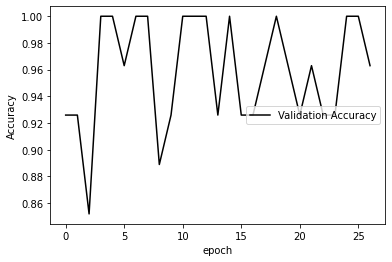

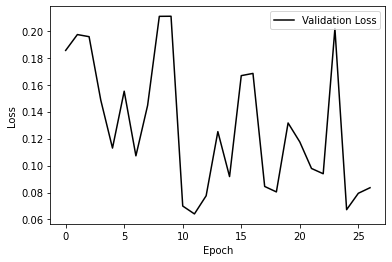

2/2 [==============================] - 2s 126ms/step - loss: 0.2219 - accuracy: 0.9118
[[23  0]
 [ 3  8]]
              precision    recall  f1-score   support

         0.0      0.885     1.000     0.939        23
         1.0      1.000     0.727     0.842        11

    accuracy                          0.912        34
   macro avg      0.942     0.864     0.890        34
weighted avg      0.922     0.912     0.907        34

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                        

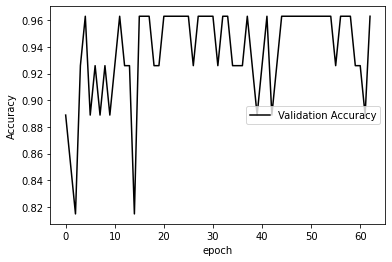

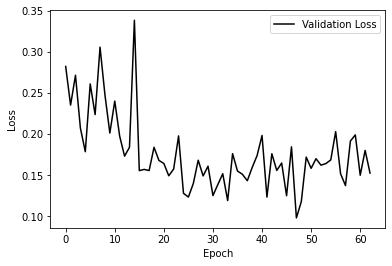

2/2 [==============================] - 2s 105ms/step - loss: 0.0802 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                        

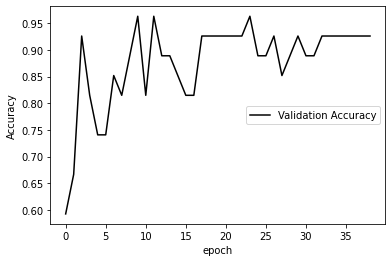

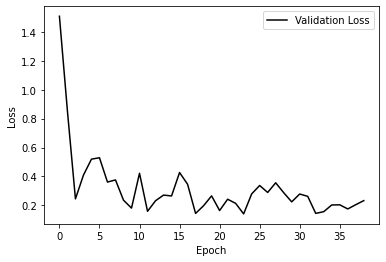

2/2 [==============================] - 2s 113ms/step - loss: 0.0939 - accuracy: 0.9706
[[22  1]
 [ 0 11]]
              precision    recall  f1-score   support

         0.0      1.000     0.957     0.978        23
         1.0      0.917     1.000     0.957        11

    accuracy                          0.971        34
   macro avg      0.958     0.978     0.967        34
weighted avg      0.973     0.971     0.971        34

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                        

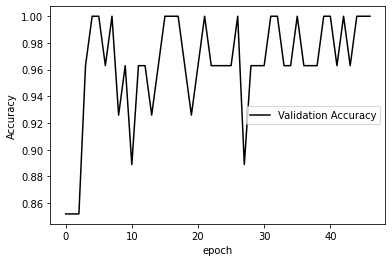

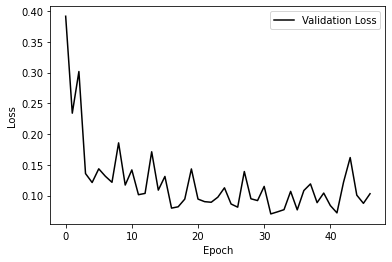

2/2 [==============================] - 2s 127ms/step - loss: 0.0521 - accuracy: 1.0000
[[23  0]
 [ 0 11]]
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        23
         1.0      1.000     1.000     1.000        11

    accuracy                          1.000        34
   macro avg      1.000     1.000     1.000        34
weighted avg      1.000     1.000     1.000        34

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                        

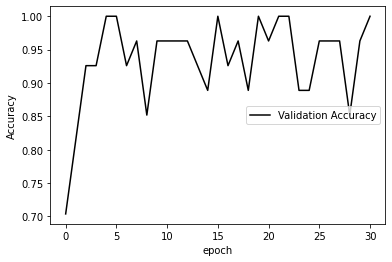

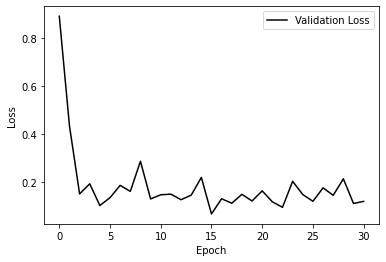

2/2 [==============================] - 2s 104ms/step - loss: 0.0765 - accuracy: 1.0000
[[22  0]
 [ 0 12]]
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        22
         1.0      1.000     1.000     1.000        12

    accuracy                          1.000        34
   macro avg      1.000     1.000     1.000        34
weighted avg      1.000     1.000     1.000        34

[0.970588219165802]
[0.964628464690646]
Epoch 1/100
28/28 [==============================] - 20s 403ms/step - loss: 0.4663 - accuracy: 0.5380 - val_loss: 0.2262 - val_accuracy: 0.9259
Epoch 2/100
28/28 [==============================] - 9s 337ms/step - loss: 0.3565 - accuracy: 0.5828 - val_loss: 0.1138 - val_accuracy: 0.9630
Epoch 3/100
28/28 [==============================] - 9s 334ms/step - loss: 0.3311 - accuracy: 0.5962 - val_loss: 0.0848 - val_accuracy: 1.0000
Epoch 4/100
28/28 [==============================] - 9s 328ms/step - loss: 0.2973 - accuracy: 0.6

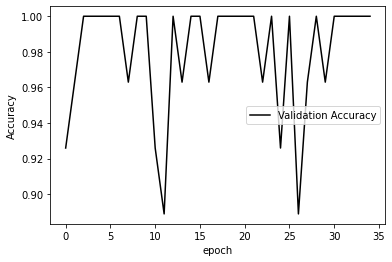

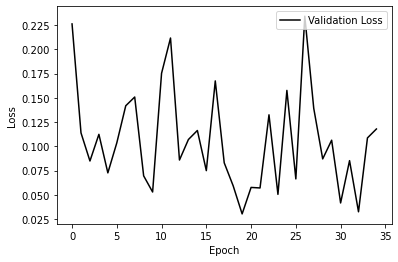

2/2 [==============================] - 2s 112ms/step - loss: 0.0836 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Epoch 1/100
27/27 [==============================] - 19s 410ms/step - loss: 0.4448 - accuracy: 0.5163 - val_loss: 0.5133 - val_accuracy: 0.8148
Epoch 2/100
27/27 [==============================] - 9s 336ms/step - loss: 0.3635 - accuracy: 0.5466 - val_loss: 0.2604 - val_accuracy: 0.8889
Epoch 3/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3328 - accuracy: 0.5618 - val_loss: 0.1719 - val_accuracy: 0.9259
Epoch 4/100
27/27 [==============================] - 9s 334ms/step - loss: 0.3097 - accuracy: 0.5641 - val_loss: 0.1882 - val_accuracy: 0

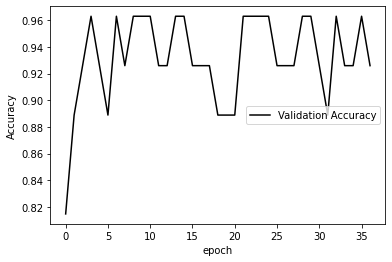

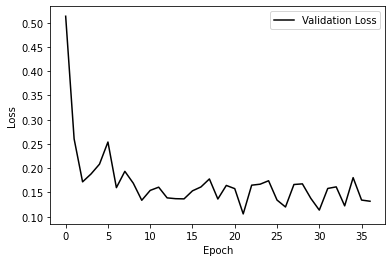

2/2 [==============================] - 2s 104ms/step - loss: 0.1353 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Epoch 1/100
27/27 [==============================] - 18s 425ms/step - loss: 0.4427 - accuracy: 0.5116 - val_loss: 1.0739 - val_accuracy: 0.6667
Epoch 2/100
27/27 [==============================] - 9s 336ms/step - loss: 0.3531 - accuracy: 0.5475 - val_loss: 0.4012 - val_accuracy: 0.7778
Epoch 3/100
27/27 [==============================] - 9s 341ms/step - loss: 0.3333 - accuracy: 0.5556 - val_loss: 0.2873 - val_accuracy: 0.8519
Epoch 4/100
27/27 [==============================] - 9s 340ms/step - loss: 0.3119 - accuracy: 0.5567 - val_loss: 0.2166 - val_accuracy: 0

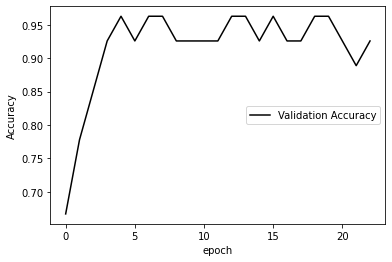

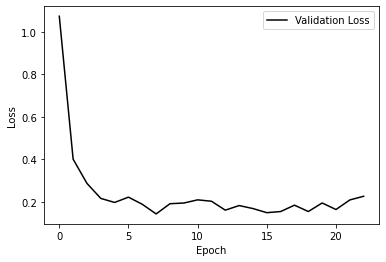

2/2 [==============================] - 2s 121ms/step - loss: 0.1307 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Epoch 1/100
27/27 [==============================] - 19s 408ms/step - loss: 0.4672 - accuracy: 0.5188 - val_loss: 1.0315 - val_accuracy: 0.5926
Epoch 2/100
27/27 [==============================] - 9s 339ms/step - loss: 0.3642 - accuracy: 0.5599 - val_loss: 0.5363 - val_accuracy: 0.7778
Epoch 3/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3246 - accuracy: 0.5669 - val_loss: 0.2122 - val_accuracy: 0.8889
Epoch 4/100
27/27 [==============================] - 9s 342ms/step - loss: 0.3056 - accuracy: 0.5728 - val_loss: 0.2074 - val_accuracy: 0

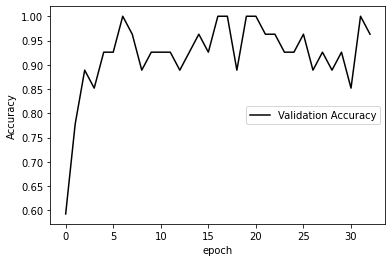

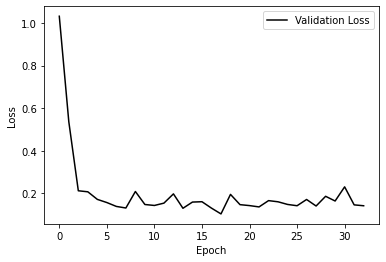

2/2 [==============================] - 2s 103ms/step - loss: 0.1401 - accuracy: 0.9412
[[23  0]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0      0.920     1.000     0.958        23
         1.0      1.000     0.818     0.900        11

    accuracy                          0.941        34
   macro avg      0.960     0.909     0.929        34
weighted avg      0.946     0.941     0.939        34

Epoch 1/100
27/27 [==============================] - 19s 409ms/step - loss: 0.4410 - accuracy: 0.5256 - val_loss: 0.5429 - val_accuracy: 0.8519
Epoch 2/100
27/27 [==============================] - 9s 336ms/step - loss: 0.3608 - accuracy: 0.5629 - val_loss: 0.2478 - val_accuracy: 0.8889
Epoch 3/100
27/27 [==============================] - 9s 340ms/step - loss: 0.3361 - accuracy: 0.5641 - val_loss: 0.1604 - val_accuracy: 0.9630
Epoch 4/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3310 - accuracy: 0.5653 - val_loss: 0.1735 - val_accuracy: 0

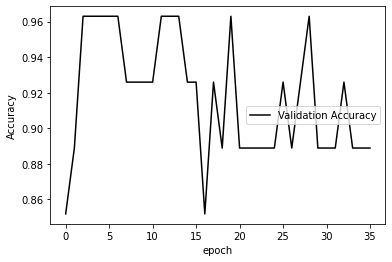

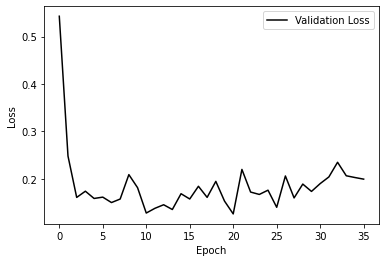

2/2 [==============================] - 2s 133ms/step - loss: 0.1181 - accuracy: 1.0000
[[22  0]
 [ 0 12]]
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        22
         1.0      1.000     1.000     1.000        12

    accuracy                          1.000        34
   macro avg      1.000     1.000     1.000        34
weighted avg      1.000     1.000     1.000        34

[0.970588219165802, 0.970588219165802]
[0.964628464690646, 0.9651646403242147]
Epoch 1/100
28/28 [==============================] - 19s 403ms/step - loss: 0.4736 - accuracy: 0.4909 - val_loss: 0.3384 - val_accuracy: 0.8519
Epoch 2/100
28/28 [==============================] - 9s 338ms/step - loss: 0.3798 - accuracy: 0.5331 - val_loss: 0.1285 - val_accuracy: 0.9259
Epoch 3/100
28/28 [==============================] - 9s 336ms/step - loss: 0.3577 - accuracy: 0.5514 - val_loss: 0.1177 - val_accuracy: 0.9630
Epoch 4/100
28/28 [==============================] - 9s 33

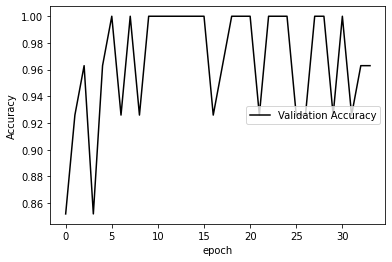

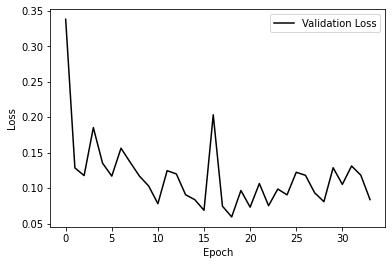

2/2 [==============================] - 2s 116ms/step - loss: 0.0979 - accuracy: 0.9412
[[23  0]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0      0.920     1.000     0.958        23
         1.0      1.000     0.818     0.900        11

    accuracy                          0.941        34
   macro avg      0.960     0.909     0.929        34
weighted avg      0.946     0.941     0.939        34

Epoch 1/100
27/27 [==============================] - 18s 423ms/step - loss: 0.4484 - accuracy: 0.5301 - val_loss: 1.2079 - val_accuracy: 0.6667
Epoch 2/100
27/27 [==============================] - 9s 335ms/step - loss: 0.3495 - accuracy: 0.5775 - val_loss: 1.2163 - val_accuracy: 0.6667
Epoch 3/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3201 - accuracy: 0.5822 - val_loss: 0.6224 - val_accuracy: 0.7407
Epoch 4/100
27/27 [==============================] - 9s 339ms/step - loss: 0.2990 - accuracy: 0.5880 - val_loss: 0.5866 - val_accuracy: 0

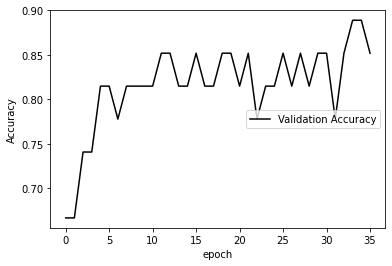

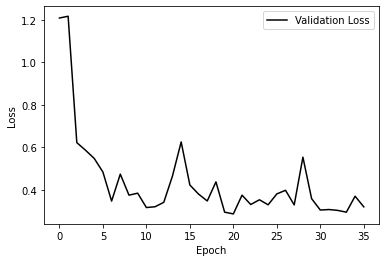

2/2 [==============================] - 2s 129ms/step - loss: 0.1055 - accuracy: 0.9706
[[22  1]
 [ 0 11]]
              precision    recall  f1-score   support

         0.0      1.000     0.957     0.978        23
         1.0      0.917     1.000     0.957        11

    accuracy                          0.971        34
   macro avg      0.958     0.978     0.967        34
weighted avg      0.973     0.971     0.971        34

Epoch 1/100
28/28 [==============================] - 20s 407ms/step - loss: 0.4396 - accuracy: 0.5263 - val_loss: 0.4794 - val_accuracy: 0.7778
Epoch 2/100
28/28 [==============================] - 9s 336ms/step - loss: 0.3446 - accuracy: 0.5776 - val_loss: 0.2093 - val_accuracy: 0.8889
Epoch 3/100
28/28 [==============================] - 9s 336ms/step - loss: 0.3318 - accuracy: 0.5833 - val_loss: 0.2085 - val_accuracy: 0.9259
Epoch 4/100
28/28 [==============================] - 9s 336ms/step - loss: 0.3105 - accuracy: 0.5845 - val_loss: 0.1463 - val_accuracy: 1

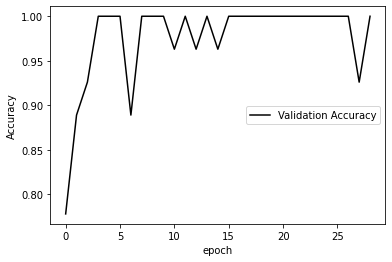

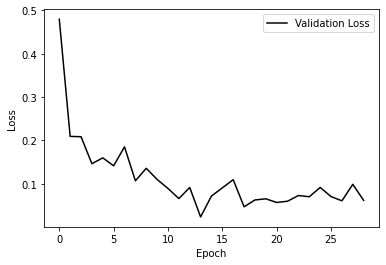

2/2 [==============================] - 2s 126ms/step - loss: 0.0625 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Epoch 1/100
29/29 [==============================] - 20s 403ms/step - loss: 0.4617 - accuracy: 0.5189 - val_loss: 0.2132 - val_accuracy: 0.9259
Epoch 2/100
29/29 [==============================] - 10s 331ms/step - loss: 0.3565 - accuracy: 0.5556 - val_loss: 0.2426 - val_accuracy: 0.8519
Epoch 3/100
29/29 [==============================] - 10s 337ms/step - loss: 0.3391 - accuracy: 0.5622 - val_loss: 0.1328 - val_accuracy: 0.9630
Epoch 4/100
29/29 [==============================] - 10s 331ms/step - loss: 0.3199 - accuracy: 0.5700 - val_loss: 0.2120 - val_accuracy

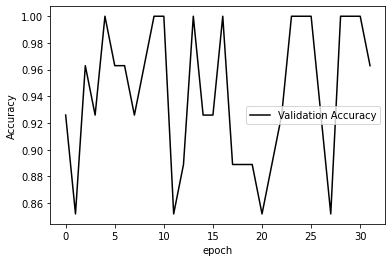

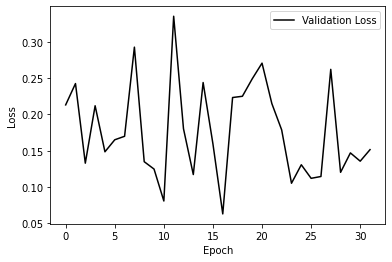

2/2 [==============================] - 2s 103ms/step - loss: 0.1701 - accuracy: 0.9412
[[23  0]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0      0.920     1.000     0.958        23
         1.0      1.000     0.818     0.900        11

    accuracy                          0.941        34
   macro avg      0.960     0.909     0.929        34
weighted avg      0.946     0.941     0.939        34

Epoch 1/100
27/27 [==============================] - 19s 407ms/step - loss: 0.4496 - accuracy: 0.5210 - val_loss: 1.0368 - val_accuracy: 0.7037
Epoch 2/100
27/27 [==============================] - 9s 336ms/step - loss: 0.3623 - accuracy: 0.5664 - val_loss: 0.8167 - val_accuracy: 0.6667
Epoch 3/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3329 - accuracy: 0.5816 - val_loss: 0.3554 - val_accuracy: 0.8148
Epoch 4/100
27/27 [==============================] - 9s 335ms/step - loss: 0.3065 - accuracy: 0.5828 - val_loss: 0.3257 - val_accuracy: 0

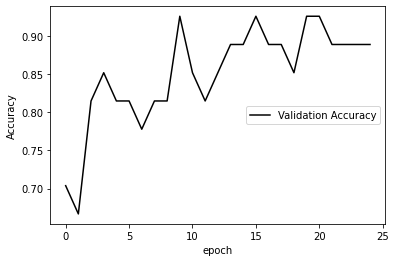

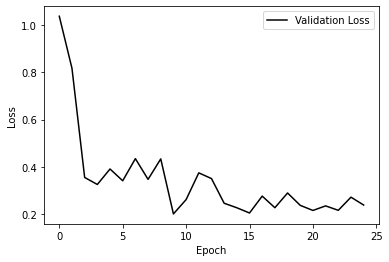

2/2 [==============================] - 2s 110ms/step - loss: 0.1919 - accuracy: 0.9118
[[22  0]
 [ 3  9]]
              precision    recall  f1-score   support

         0.0      0.880     1.000     0.936        22
         1.0      1.000     0.750     0.857        12

    accuracy                          0.912        34
   macro avg      0.940     0.875     0.897        34
weighted avg      0.922     0.912     0.908        34

[0.970588219165802, 0.970588219165802, 0.9470588088035583]
[0.964628464690646, 0.9651646403242147, 0.9375383610119966]
Epoch 1/100
28/28 [==============================] - 20s 405ms/step - loss: 0.4402 - accuracy: 0.5193 - val_loss: 0.1926 - val_accuracy: 0.9259
Epoch 2/100
28/28 [==============================] - 9s 332ms/step - loss: 0.3511 - accuracy: 0.5601 - val_loss: 0.2505 - val_accuracy: 0.8889
Epoch 3/100
28/28 [==============================] - 9s 332ms/step - loss: 0.3324 - accuracy: 0.5612 - val_loss: 0.3378 - val_accuracy: 0.8519
Epoch 4/100
28/28 

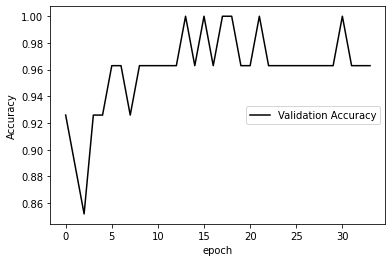

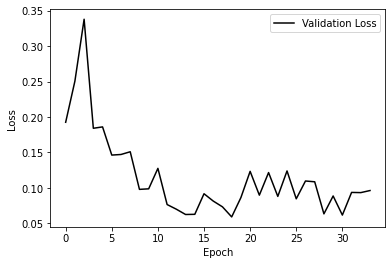

2/2 [==============================] - 2s 105ms/step - loss: 0.1795 - accuracy: 0.9412
[[23  0]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0      0.920     1.000     0.958        23
         1.0      1.000     0.818     0.900        11

    accuracy                          0.941        34
   macro avg      0.960     0.909     0.929        34
weighted avg      0.946     0.941     0.939        34

Epoch 1/100
27/27 [==============================] - 19s 407ms/step - loss: 0.4561 - accuracy: 0.5293 - val_loss: 0.6481 - val_accuracy: 0.7407
Epoch 2/100
27/27 [==============================] - 9s 335ms/step - loss: 0.3478 - accuracy: 0.5669 - val_loss: 0.3042 - val_accuracy: 0.8519
Epoch 3/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3411 - accuracy: 0.5692 - val_loss: 0.2760 - val_accuracy: 0.8889
Epoch 4/100
27/27 [==============================] - 9s 336ms/step - loss: 0.3220 - accuracy: 0.5657 - val_loss: 0.1790 - val_accuracy: 0

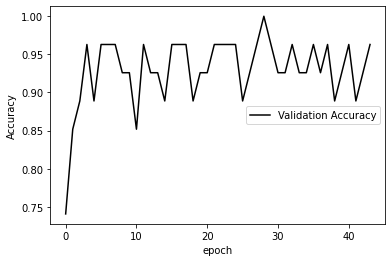

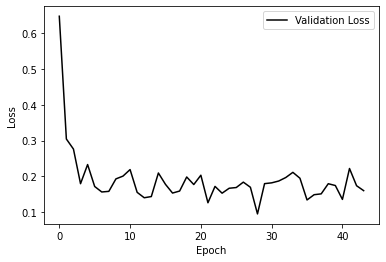

2/2 [==============================] - 2s 112ms/step - loss: 0.0687 - accuracy: 1.0000
[[23  0]
 [ 0 11]]
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        23
         1.0      1.000     1.000     1.000        11

    accuracy                          1.000        34
   macro avg      1.000     1.000     1.000        34
weighted avg      1.000     1.000     1.000        34

Epoch 1/100
27/27 [==============================] - 19s 403ms/step - loss: 0.4127 - accuracy: 0.5606 - val_loss: 1.8707 - val_accuracy: 0.5926
Epoch 2/100
27/27 [==============================] - 9s 334ms/step - loss: 0.3325 - accuracy: 0.5839 - val_loss: 0.6276 - val_accuracy: 0.7407
Epoch 3/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3001 - accuracy: 0.5991 - val_loss: 0.4289 - val_accuracy: 0.8519
Epoch 4/100
27/27 [==============================] - 9s 336ms/step - loss: 0.2981 - accuracy: 0.5979 - val_loss: 0.4211 - val_accuracy: 0

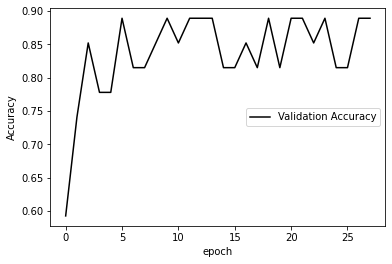

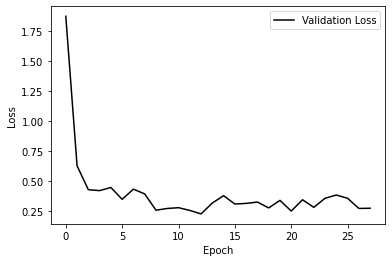

2/2 [==============================] - 2s 109ms/step - loss: 0.1020 - accuracy: 1.0000
[[23  0]
 [ 0 11]]
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        23
         1.0      1.000     1.000     1.000        11

    accuracy                          1.000        34
   macro avg      1.000     1.000     1.000        34
weighted avg      1.000     1.000     1.000        34

Epoch 1/100
28/28 [==============================] - 19s 401ms/step - loss: 0.5076 - accuracy: 0.5101 - val_loss: 0.3994 - val_accuracy: 0.8889
Epoch 2/100
28/28 [==============================] - 9s 337ms/step - loss: 0.3795 - accuracy: 0.5608 - val_loss: 0.1020 - val_accuracy: 0.9630
Epoch 3/100
28/28 [==============================] - 9s 338ms/step - loss: 0.3253 - accuracy: 0.5833 - val_loss: 0.1012 - val_accuracy: 1.0000
Epoch 4/100
28/28 [==============================] - 9s 333ms/step - loss: 0.3135 - accuracy: 0.5833 - val_loss: 0.1133 - val_accuracy: 1

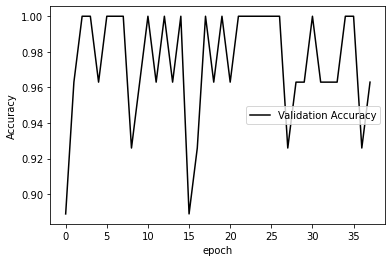

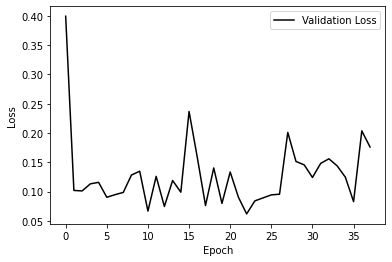

2/2 [==============================] - 2s 134ms/step - loss: 0.1090 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Epoch 1/100
27/27 [==============================] - 19s 408ms/step - loss: 0.4238 - accuracy: 0.5420 - val_loss: 0.4499 - val_accuracy: 0.7407
Epoch 2/100
27/27 [==============================] - 9s 336ms/step - loss: 0.3561 - accuracy: 0.5641 - val_loss: 0.4906 - val_accuracy: 0.7407
Epoch 3/100
27/27 [==============================] - 9s 335ms/step - loss: 0.3306 - accuracy: 0.5676 - val_loss: 0.5844 - val_accuracy: 0.7778
Epoch 4/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3166 - accuracy: 0.5746 - val_loss: 0.2582 - val_accuracy: 0

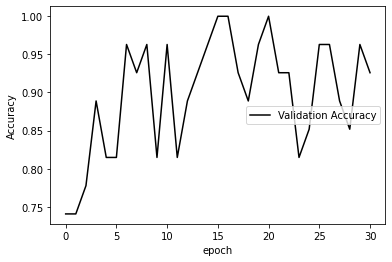

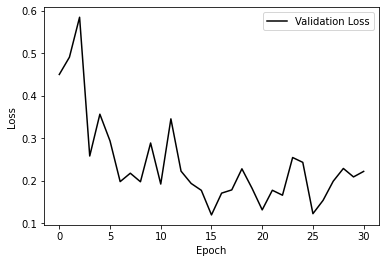

2/2 [==============================] - 2s 110ms/step - loss: 0.1569 - accuracy: 0.9706
[[22  0]
 [ 1 11]]
              precision    recall  f1-score   support

         0.0      0.957     1.000     0.978        22
         1.0      1.000     0.917     0.957        12

    accuracy                          0.971        34
   macro avg      0.978     0.958     0.967        34
weighted avg      0.972     0.971     0.970        34

[0.970588219165802, 0.970588219165802, 0.9470588088035583, 0.9764705777168274]
[0.964628464690646, 0.9651646403242147, 0.9375383610119966, 0.9723737206877818]
Epoch 1/100
27/27 [==============================] - 18s 422ms/step - loss: 0.4286 - accuracy: 0.5509 - val_loss: 0.3918 - val_accuracy: 0.8519
Epoch 2/100
27/27 [==============================] - 9s 338ms/step - loss: 0.3509 - accuracy: 0.5880 - val_loss: 0.2778 - val_accuracy: 0.9259
Epoch 3/100
27/27 [==============================] - 9s 336ms/step - loss: 0.3196 - accuracy: 0.5914 - val_loss: 0.3690 -

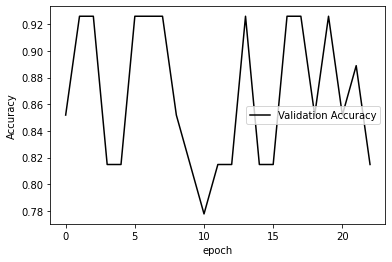

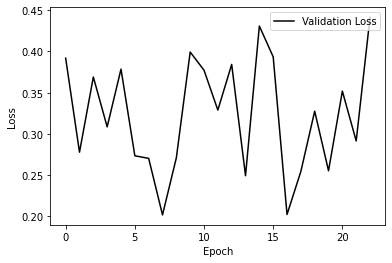

2/2 [==============================] - 2s 110ms/step - loss: 0.1425 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Epoch 1/100
28/28 [==============================] - 19s 405ms/step - loss: 0.4478 - accuracy: 0.5251 - val_loss: 0.3719 - val_accuracy: 0.8889
Epoch 2/100
28/28 [==============================] - 9s 338ms/step - loss: 0.3594 - accuracy: 0.5765 - val_loss: 0.2328 - val_accuracy: 0.8889
Epoch 3/100
28/28 [==============================] - 9s 334ms/step - loss: 0.3215 - accuracy: 0.5868 - val_loss: 0.2866 - val_accuracy: 0.8889
Epoch 4/100
28/28 [==============================] - 9s 336ms/step - loss: 0.3144 - accuracy: 0.5833 - val_loss: 0.1718 - val_accuracy: 0

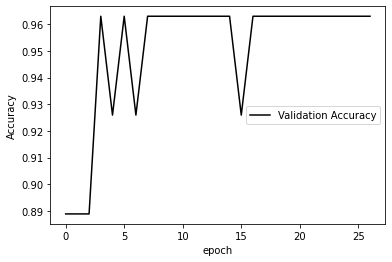

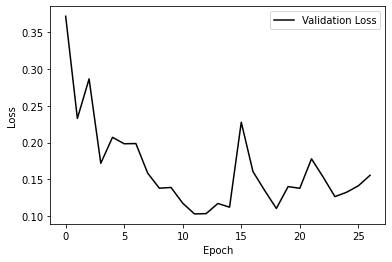

2/2 [==============================] - 2s 110ms/step - loss: 0.1313 - accuracy: 0.9412
[[23  0]
 [ 2  9]]
              precision    recall  f1-score   support

         0.0      0.920     1.000     0.958        23
         1.0      1.000     0.818     0.900        11

    accuracy                          0.941        34
   macro avg      0.960     0.909     0.929        34
weighted avg      0.946     0.941     0.939        34

Epoch 1/100
28/28 [==============================] - 19s 400ms/step - loss: 0.4715 - accuracy: 0.5379 - val_loss: 0.6059 - val_accuracy: 0.7407
Epoch 2/100
28/28 [==============================] - 9s 333ms/step - loss: 0.3535 - accuracy: 0.5805 - val_loss: 0.4026 - val_accuracy: 0.7778
Epoch 3/100
28/28 [==============================] - 9s 329ms/step - loss: 0.3368 - accuracy: 0.5828 - val_loss: 0.2644 - val_accuracy: 0.9259
Epoch 4/100
28/28 [==============================] - 9s 336ms/step - loss: 0.3041 - accuracy: 0.5943 - val_loss: 0.1883 - val_accuracy: 0

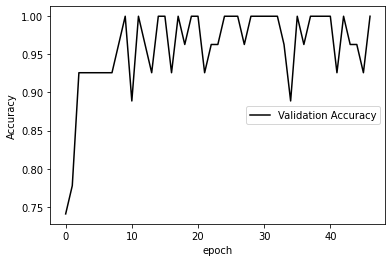

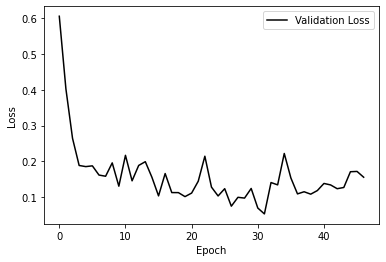

2/2 [==============================] - 2s 105ms/step - loss: 0.1220 - accuracy: 0.9412
[[22  1]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.957     0.957     0.957        23
         1.0      0.909     0.909     0.909        11

    accuracy                          0.941        34
   macro avg      0.933     0.933     0.933        34
weighted avg      0.941     0.941     0.941        34

Epoch 1/100
28/28 [==============================] - 20s 409ms/step - loss: 0.4477 - accuracy: 0.5402 - val_loss: 0.5768 - val_accuracy: 0.8148
Epoch 2/100
28/28 [==============================] - 10s 341ms/step - loss: 0.3583 - accuracy: 0.5747 - val_loss: 0.3918 - val_accuracy: 0.8519
Epoch 3/100
28/28 [==============================] - 9s 339ms/step - loss: 0.3597 - accuracy: 0.5828 - val_loss: 0.1960 - val_accuracy: 0.8889
Epoch 4/100
28/28 [==============================] - 9s 339ms/step - loss: 0.3203 - accuracy: 0.5897 - val_loss: 0.1859 - val_accuracy: 

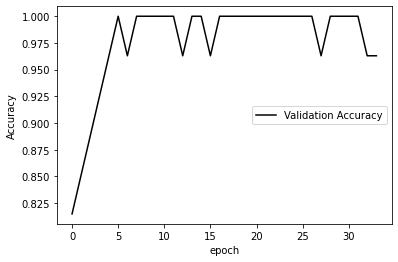

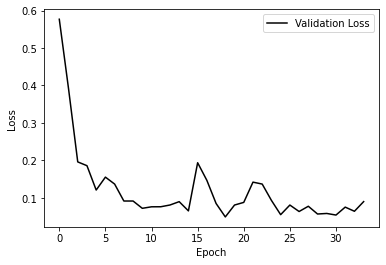

2/2 [==============================] - 2s 106ms/step - loss: 0.1317 - accuracy: 0.9706
[[23  0]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0      0.958     1.000     0.979        23
         1.0      1.000     0.909     0.952        11

    accuracy                          0.971        34
   macro avg      0.979     0.955     0.966        34
weighted avg      0.972     0.971     0.970        34

Epoch 1/100
27/27 [==============================] - 20s 413ms/step - loss: 0.4513 - accuracy: 0.5256 - val_loss: 0.5658 - val_accuracy: 0.7778
Epoch 2/100
27/27 [==============================] - 9s 343ms/step - loss: 0.3548 - accuracy: 0.5758 - val_loss: 0.4111 - val_accuracy: 0.7778
Epoch 3/100
27/27 [==============================] - 9s 341ms/step - loss: 0.3492 - accuracy: 0.5699 - val_loss: 0.3545 - val_accuracy: 0.8148
Epoch 4/100
27/27 [==============================] - 9s 337ms/step - loss: 0.3168 - accuracy: 0.5804 - val_loss: 0.4768 - val_accuracy: 0

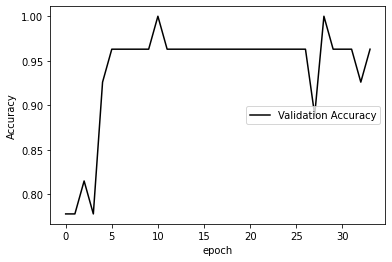

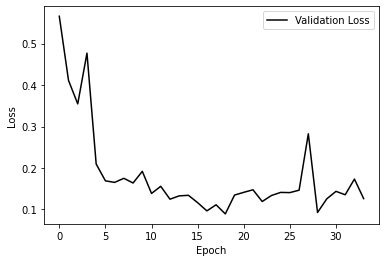

2/2 [==============================] - 2s 134ms/step - loss: 0.1645 - accuracy: 0.9412
[[22  0]
 [ 2 10]]
              precision    recall  f1-score   support

         0.0      0.917     1.000     0.957        22
         1.0      1.000     0.833     0.909        12

    accuracy                          0.941        34
   macro avg      0.958     0.917     0.933        34
weighted avg      0.946     0.941     0.940        34

[0.970588219165802, 0.970588219165802, 0.9470588088035583, 0.9764705777168274, 0.9529411673545838]
[0.964628464690646, 0.9651646403242147, 0.9375383610119966, 0.9723737206877818, 0.9451767343048564]
Mean test accuracy is 0.964, mean test f1 score is 0.957, max test accuracy is 0.976, max test f1 score is 0.972, min test accuracy is 0.947, min test f1 score is 0.938, std of test accuracy is 0.011, std of test f1 score is 0.013
Time elapsed through all process: 8735.194, sec


In [12]:
t = time.time()
# ---------- Parameters ----------------
augmentation_enable = True
normalize_inputs_enable = True
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = None) # random_state = 1 ile split run'dan run'a sabit.
test_accuracy_per_run = []
f1_score_per_run = []
epoch_number =   100 # 100
batch_size = 32
dense_size = 64
dropout_prob_dense = 0.3 # 0.
repeat_of_mixup = 5
number_of_repeat = 5
unit_number_of_lstm = 16 #8 16 32
dense_unit_of_range_doppler_function = 256 #128 256 512
dense_unit_of_spectrogram_function = 8
decoder_dense_unit = 256
for repeat_run_number in range(number_of_repeat):
  test_accuracy_per_fold = []
  f1_score_per_fold = []
  if repeat_run_number > 0:
    del range_doppler_concat_shuffle_test
    del spectrogram_concat_shuffle_test
    del range_doppler_augmented_image
    del range_doppler_concat_shuffle_train
    del spectrogram_concat_shuffle_train
    del spectrogram_augmented_image
   
  for randomlist_for_train_indx, randomlist_for_test_indx in kfold.split(range_doppler_concat_shuffle,range_doppler_concat_label_shuffle):   
    gc.collect()
    K.clear_session()
    
    # test data
    range_doppler_concat_shuffle_test = range_doppler_concat_shuffle[randomlist_for_test_indx,:,:,:]
    spectrogram_concat_shuffle_test = spectrogram_concat_shuffle[randomlist_for_test_indx,:,:,:]
    range_doppler_concat_label_shuffle_test = range_doppler_concat_label_shuffle[randomlist_for_test_indx,:]
    #train data
    range_doppler_concat_shuffle_train = range_doppler_concat_shuffle[randomlist_for_train_indx,:,:,:]
    spectrogram_concat_shuffle_train = spectrogram_concat_shuffle[randomlist_for_train_indx,:,:,:]
    spectrogram_concat_label_shuffle_train = spectrogram_concat_label_shuffle[randomlist_for_train_indx,:]
      # ---------------- MixUp Augmentation ----------------
    (spectrogram_augmented_image,range_doppler_augmented_image,spectrogram_concat_label_shuffle_concat,\
     validation_spectrogram,validation_range_doppler, spectrogram_validation_labels)  =\
      split_and_augmentation_of_training(spectrogram_concat_shuffle_train,range_doppler_concat_shuffle_train,\
                                         spectrogram_concat_label_shuffle_train,\
                                         repeat_of_mixup, augmentation_enable)
    
    # ---------------- Neural Network Architecture ----------------



    def lstm_encoder_network_1(input_shape):
        input = Input(shape=input_shape)
        x = Bidirectional(LSTM(unit_number_of_lstm, return_sequences=True, dropout = 0.5))(input)
        x = Flatten()(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(dense_unit_of_range_doppler_function)(x)
        x = BatchNormalization()(x)
        x = Activation('LeakyReLU')(x)
        x = Dropout(dropout_prob_dense)(x)
        return Model(input, x)

    def lstm_encoder_network_2(input_shape):
        input = Input(shape=input_shape)
        x = Bidirectional(LSTM(unit_number_of_lstm, return_sequences=True, dropout = 0.5))(input)
        x = Flatten()(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(dense_unit_of_spectrogram_function)(x)
        x = BatchNormalization()(x)
        x = Activation('LeakyReLU')(x)
        x = Dropout(dropout_prob_dense)(x)
        return Model(input, x)

    def decoder_for_concat(input_shape):
      input = Input(shape=input_shape)
      x = Dense(decoder_dense_unit)(input)
      x = BatchNormalization()(x)
      x = Activation('LeakyReLU')(x)
      x = Dropout(0.3)(x)
      x = Dense(dense_size)(x)
      # x = BatchNormalization()(x)
      x = Activation('LeakyReLU')(x)
      x = Dropout(dropout_prob_dense)(x)
      x = Dense(1, activation="sigmoid")(x)
      return Model(input, x)

    input_shape = range_doppler_concat_shuffle.shape[1:3]
    base_network_lstm = lstm_encoder_network_1(input_shape)
    range_doppler_input  = Input(shape=input_shape)
    processed_range_doppler  = base_network_lstm(range_doppler_input)

    input_shape = spectrogram_concat_shuffle_train.shape[1:3]
    base_network_lstm_2 = lstm_encoder_network_2(input_shape)
    spectrogram_input  = Input(shape=input_shape)
    processed_spectrogram  = base_network_lstm_2(spectrogram_input)

    concat_layer = Concatenate()([processed_range_doppler, processed_spectrogram])

    base_decoder_network = decoder_for_concat((concat_layer.shape[1]))
    out = base_decoder_network(concat_layer)

    model = Model(inputs=[range_doppler_input, spectrogram_input], outputs=[out]) 
    if repeat_run_number == 0:
      print(base_network_lstm.summary())
      print(base_network_lstm_2.summary())
      print(base_decoder_network.summary())
    # ---------------- Compile and Fit ----------------
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0,restore_best_weights=True, mode='min')
    history = model.fit((range_doppler_augmented_image, spectrogram_augmented_image),(spectrogram_concat_label_shuffle_concat),
                    epochs=epoch_number,
                    batch_size=batch_size,
                    shuffle = True,
                    callbacks=[earlyStopping],
                    validation_data = ((validation_range_doppler, validation_spectrogram) , (spectrogram_validation_labels)))
    #plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'],color="black")
    #plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Validation Accuracy'], loc='right')
    #plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='right')
    plt.show()
    # summarize history for loss
    # plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'],color="black")
    #plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Validation Loss'], loc='upper right')
    plt.show()


    test_loss, test_accuracy  = model.evaluate([range_doppler_concat_shuffle_test, spectrogram_concat_shuffle_test],\
                                               [range_doppler_concat_label_shuffle_test],
                  batch_size=batch_size)
    gc.collect()
    # ---------------- Get Test Results ----------------
    y_test_predicted = model.predict((range_doppler_concat_shuffle_test, spectrogram_concat_shuffle_test), batch_size=batch_size)
    # ----- Binarize y_test_predicted values -----
    y_test_predicted_binary = np.zeros(y_test_predicted.size)
    for ii in range(y_test_predicted.size):
      if y_test_predicted[ii] < 0.5:
        y_test_predicted_binary[ii] = 0
      else:
        y_test_predicted_binary[ii] = 1
    
    test_precision, test_recall, test_f1_score, support = precision_recall_fscore_support(range_doppler_concat_label_shuffle_test, y_test_predicted_binary, average='macro')

    print(confusion_matrix(range_doppler_concat_label_shuffle_test, y_test_predicted_binary))
    print(classification_report(range_doppler_concat_label_shuffle_test, y_test_predicted_binary, digits=3))


    test_accuracy_per_fold.append(test_accuracy)
    f1_score_per_fold.append(test_f1_score)
    del model
  test_accuracy_per_run.append(sum(test_accuracy_per_fold)/num_folds)
  f1_score_per_run.append(sum(f1_score_per_fold)/num_folds)
  print(test_accuracy_per_run)
  print(f1_score_per_run)
print(f'Mean test accuracy is {"{:.3f}".format(sum(test_accuracy_per_run)/number_of_repeat)}, mean test f1 score is {"{:.3f}".format(sum(f1_score_per_run)/number_of_repeat)}, \
max test accuracy is {"{:.3f}".format(max(test_accuracy_per_run))}, max test f1 score is {"{:.3f}".format(max(f1_score_per_run))}, \
min test accuracy is {"{:.3f}".format(min(test_accuracy_per_run))}, min test f1 score is {"{:.3f}".format(min(f1_score_per_run))}, \
std of test accuracy is {"{:.3f}".format(np.std(test_accuracy_per_run, axis=0))}, std of test f1 score is {"{:.3f}".format(np.std(f1_score_per_run, axis=0))}')
elapsed = time.time() - t
print(f'Time elapsed through all process: {"{:.3f}".format(elapsed)}, sec')

In [ ]:
print(f'Mean test accuracy is {"{:.3f}".format(sum(test_accuracy_per_run)/number_of_repeat)}, mean test f1 score is {"{:.3f}".format(sum(f1_score_per_run)/number_of_repeat)}, \
max test accuracy is {"{:.3f}".format(max(test_accuracy_per_run))}, max test f1 score is {"{:.3f}".format(max(f1_score_per_run))}, \
min test accuracy is {"{:.3f}".format(min(test_accuracy_per_run))}, min test f1 score is {"{:.3f}".format(min(f1_score_per_run))}, \
std of test accuracy is {"{:.3f}".format(np.std(test_accuracy_per_run, axis=0))}, std of test f1 score is {"{:.3f}".format(np.std(f1_score_per_run, axis=0))}')
print(f'Time elapsed through all process: {"{:.3f}".format(elapsed)}, sec')

NameError: ignored

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
def createList(n):
    lst = []
    for i in range(n+1):
        lst.append(i)
    return(lst)


folds = createList(4)
values = [element * 100 for element in test_accuracy_per_fold]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(folds, values, color ='black',
        width = 0.4)
plt.xlabel("Accuracy vs k-run")
plt.ylabel("Accuracy")
plt.show()

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(folds, f1_score_per_fold, color ='black',
        width = 0.4)
plt.xlabel("F1 Score vs k-run")
plt.ylabel("F1 Score")
plt.show()



NameError: ignored